# Ćwiczenie 2 - Mapowanie Parków Narodowych w Polsce

Celem ćwiczenia jest przygotowanie mapy z lokalizacją siedzib parków narodowych w Polsce. Należy ustawić symbolizacje na logo siedziby parku.

Dodatkowe zależności:
```bash
conda install -c anaconda lxml
conda install -c anaconda html5lib
conda install -c anaconda beautifulsoup4
conda install -c anaconda matplotlib
```

In [157]:
#Ładuję wymagane moduły: ArcGIS dla interakcji z mapą, Pandas dla interakcji z danymi
from arcgis.gis import GIS
import pandas as pd

In [164]:
#Test działania mapy
my_gis = GIS()
my_gis.map()

In [166]:
#Ładujemy dane odnośnie parków narodowych z wikipedii
df = pd.read_html('http://pl.wikipedia.org/wiki/Parki_narodowe_w_Polsce')
#Pandas szuka na stronie tabel, które może zamienić w ramki danych, należy przeanalizować dane i wybrać interesująca nas tabele
df = pd.read_html('http://pl.wikipedia.org/wiki/Parki_narodowe_w_Polsce', header=0, skiprows=[24])[0]
#Nie potrzebujemy wszystkich kolumn, zawężamy więc tylko do kilku potrzebnych do wykonania zadania (Nazwa, Symbol, Siedziba)
df = df[df.columns[[1,3,6]]]
#Zwrócić uwagę na to że Logo pojawia się jako NaN
df.head()

,Nazwa parku,Symbol,Siedziba
0,Babiogórski Park Narodowy,okrzyn jeleni,Zawoja
1,Białowieski Park Narodowy,żubr,Białowieża
2,Biebrzański Park Narodowy,batalion (bojownik),Osowiec-Twierdza
3,Bieszczadzki Park Narodowy,ryś,Ustrzyki Górne
4,Bory TucholskiePark Narodowy „Bory Tucholskie”,głuszec,Charzykowy


In [160]:
#Tworzymy wizualizacje danych dotyczących parków
gis = GIS()
fc = gis.content.import_data(df, {"Address":"Siedziba"})
map1 = gis.map('Poland')
map1.add_layer(fc)
map1

In [161]:
#Musimy dodać informację dotyczącą adresu URL miniatur, w tym celu korzystamy z biblioteki BeautifulSoup
from bs4 import BeautifulSoup
import requests
#Ładujemy strone wiki
page = requests.get('http://pl.wikipedia.org/wiki/Parki_narodowe_w_Polsce')
soup = BeautifulSoup(page.text, "lxml")
#Szukamy tabeli z parkami
table = soup.find_all('table')[0]
#Wybieramy wszystkie obrazki
tags = table.find_all('img')
src_list = []
#Dodajemy źródła obrazków do listy
for tag in tags:
    src_list.append(tag['src'])

#Tworzymi ramkę danych pandas
img_df = pd.DataFrame(src_list, columns=['Logo'])
img_df.head()

,Logo
0,//upload.wikimedia.org/wikipedia/commons/thumb...
1,//upload.wikimedia.org/wikipedia/commons/thumb...
2,//upload.wikimedia.org/wikipedia/commons/thumb...
3,//upload.wikimedia.org/wikipedia/commons/thumb...
4,//upload.wikimedia.org/wikipedia/commons/thumb...


In [162]:
#Łączymy dane
final_df = df.merge(img_df, left_index=True, right_index=True)
final_df.head()

,Nazwa parku,Symbol,Siedziba,Logo
0,Babiogórski Park Narodowy,okrzyn jeleni,Zawoja,//upload.wikimedia.org/wikipedia/commons/thumb...
1,Białowieski Park Narodowy,żubr,Białowieża,//upload.wikimedia.org/wikipedia/commons/thumb...
2,Biebrzański Park Narodowy,batalion (bojownik),Osowiec-Twierdza,//upload.wikimedia.org/wikipedia/commons/thumb...
3,Bieszczadzki Park Narodowy,ryś,Ustrzyki Górne,//upload.wikimedia.org/wikipedia/commons/thumb...
4,Bory TucholskiePark Narodowy „Bory Tucholskie”,głuszec,Charzykowy,//upload.wikimedia.org/wikipedia/commons/thumb...


In [163]:
#Aby utworzyć symbolizacje parków musimy stworzyć renderer dla naszej warstwy, związane jest to z ArcGIS JavaScript API oraz
#Sposobem wizualizacji danych w "Web ArcGISie"

#Tworzymy słownik renderer
renderer = {
    "type" : "uniqueValue",
    "field1" : "Symbol",
    "uniqueValueInfos": []
}
#Iterując ramkę danych uzupełniamy informacje na temat symboli naszego renderera
for row in final_df[['Symbol', 'Logo']].iterrows():
    #print(row[1][0])
    renderer['uniqueValueInfos'].append({
    "value": row[1][0],
    "symbol": {
        "angle": -360,
        "xoffset": 0,
        "yoffset": 0,
        "type": "esriPMS",
        "url": row[1][1],
        "width": 37.5,
        "height": 37.5    
            }
    })
#Dodajemy defaultowy symbol (dla uniknięcia dziwnych błędów API)
renderer['defaultSymbol'] = renderer['uniqueValueInfos'][0]['symbol']
#Tworzymy nowy feature class
fc = gis.content.import_data(final_df, {"Address":"Siedziba"})
#przypisujemy dla nowoutworzonego fc nowy renderer
fc.properties['layerDefinition']['drawingInfo']['renderer'] = renderer
#tworzymy mape
map2 = gis.map('Poland')
map2.add_layer(fc)
map2

## Inne przykłady

In [171]:
df2 = pd.read_html('http://pl.wikipedia.org/wiki/Parki_narodowe_w_Polsce', header=0, skiprows=[24])[0]
#Nie potrzebujemy wszystkich kolumn, zawężamy więc tylko do kilku potrzebnych do wykonania zadania (Nazwa, Symbol, Siedziba)
df2 = df2[df2.columns[[1,3,4,6]]]
df2.head()

,Nazwa parku,Symbol,Utworzono,Siedziba
0,Babiogórski Park Narodowy,okrzyn jeleni,1954,Zawoja
1,Białowieski Park Narodowy,żubr,1932,Białowieża
2,Biebrzański Park Narodowy,batalion (bojownik),1993,Osowiec-Twierdza
3,Bieszczadzki Park Narodowy,ryś,1973,Ustrzyki Górne
4,Bory TucholskiePark Narodowy „Bory Tucholskie”,głuszec,1996,Charzykowy


In [176]:
fc2 = gis.content.import_data(df2, {"Address":"Siedziba"})
map3 = gis.map('Poland')
map3.add_layer(fc2, {"renderer":"ClassedSizeRenderer",
               "field_name": "Utworzono"})
map3

In [181]:
df2.sort_values('Utworzono', inplace=True)
df2.head()

,Nazwa parku,Symbol,Utworzono,Siedziba
1,Białowieski Park Narodowy,żubr,1932,Białowieża
13,Pieniński Park Narodowy,Trzy Korony,1932,Krościenko nad Dunajcem
17,SzzwiętokrzyskiŚwiętokrzyski Park Narodowy,jeleń,1950,Bodzentyn
0,Babiogórski Park Narodowy,okrzyn jeleni,1954,Zawoja
18,Tatrzański Park Narodowy,kozica tatrzańska,1954,Zakopane


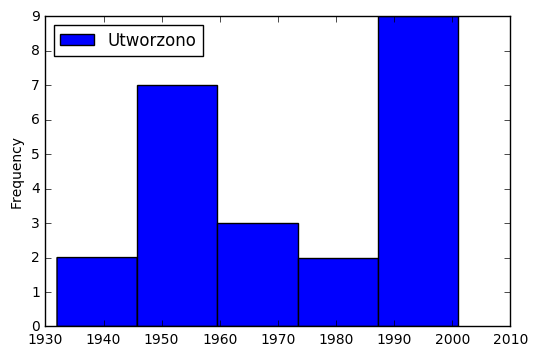

In [185]:
import matplotlib as plt
%matplotlib inline

ax = df2.plot.hist(by='Utworzono', bins=5)